In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
import tqdm
import multiprocessing as mp
from config import *

path = result_parent_directory + os.sep + 'step4c_btms_sizing_sensitivity_wait_time'
path_no_wait = result_parent_directory + os.sep + 'step4_btms_sizing_sensitivity'

result_directory = path + os.sep + 'analysis'
os.makedirs(result_directory, exist_ok=True)
figure_directory = path + os.sep + 'figures'
os.makedirs(figure_directory, exist_ok=True)

sizing_results_path = os.path.join(path, 'sizing_results')

print('Loading results from {}'.format(sizing_results_path))
print('Loading no wait results from {}'.format(path_no_wait))
print('result_directory: {}'.format(result_directory))
print('figure_directory: {}'.format(figure_directory))

Loading results from results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\sizing_results
Loading no wait results from results\advancedScenario7\step4_btms_sizing_sensitivity
result_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\analysis
figure_directory: results\advancedScenario7\step4c_btms_sizing_sensitivity_wait_time\figures


In [2]:
# sort files into folders with a_cost_sizing and d_wait_cost as folder names
# a_cost_sizing is top folder, d_wait_cost is subfolder

folder_sorted_sizing = 'sorted_sizing'
for folder1 in os.listdir(sizing_results_path):
    if not folder1.startswith(folder_sorted_sizing):
        path_folder = os.path.join(sizing_results_path, folder1)
        # load a_cost_sizing and d_wait_cost from first file in dir
        file = os.listdir(path_folder)[0]
        path_file = os.path.join(path_folder, file)
        df = pd.read_csv(path_file)
        a = float(df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][1]) * (365/12)
        d = df['param: btms size, a,b_sys,b_cap,b_loan,c,d_wait_cost'][6]
        # create folder structure
        # round a 
        path_folder_new = os.path.join(sizing_results_path, folder_sorted_sizing, 'a_' + str(round(a)))
        os.makedirs(path_folder_new, exist_ok=True)
        path_folder_new = os.path.join(path_folder_new, 'd_' + str(int(d)))
        os.makedirs(path_folder_new, exist_ok=True)
        # move files
        for file in os.listdir(path_folder):
            path_file = os.path.join(path_folder, file)
            shutil.move(path_file, path_folder_new)
        # remove empty folder
        os.rmdir(path_folder)

In [3]:
from functions.stats_sizing_function import stats_sizing_function_wait_time
# calculate stats for each charging station and save them in list and add multiindex: top-level: a_cost_sizing, second-level: d_wait_cost
stats_list = []

sizing_results_sorted = os.path.join(sizing_results_path, folder_sorted_sizing)
for folder1 in os.listdir(sizing_results_sorted):
    path_folder1 = os.path.join(sizing_results_sorted, folder1)
    # read a value from folder name
    a_value = float(folder1.split('_')[1])
    for folder2 in os.listdir(path_folder1):
        # read d value from folder name
        d_value = float(folder2.split('_')[1])
        path_folder2 = os.path.join(path_folder1, folder2)
        stats_i = []
        station_ids = []
        for file in os.listdir(path_folder2):
            station_id = int(file.split('.')[0].split('_')[2])
            station_ids.append(station_id)
            stats_i.append(stats_sizing_function_wait_time(pd.read_csv(os.path.join(path_folder2, file)), timestep))
        stats_i = pd.DataFrame(stats_i, index=station_ids)
        # make multiindex with a and d values
        stats_i.index = pd.MultiIndex.from_product([[a_value], [d_value], stats_i.index], names=['a', 'd', 'station_id'])
        # save stats in list
        stats_list.append(stats_i)
# concatenate all stats in one dataframe
stats_sizing = pd.concat(stats_list)
stats_sizing.sort_index(inplace=True)

In [4]:
index = stats_sizing.index
print('a_values: ', index.get_level_values(0).unique())
print('d_values: ', index.get_level_values(1).unique())
columns = stats_sizing.columns
print(columns)

a_values:  Float64Index([2.0, 5.0, 8.0, 10.0, 15.0], dtype='float64', name='a')
d_values:  Float64Index([0.0, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0, 1000000.0], dtype='float64', name='d')
Index(['btms_size', 'cost_a', 'cost_b_sys', 'cost_b_cap', 'cost_b_loan',
       'cost_b', 'cost_c', 'cost_total', 'share_cost_a', 'share_cost_b_sys',
       'share_cost_b_cap', 'share_cost_b_loan', 'share_cost_b', 'share_cost_c',
       'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor',
       'btms_peak_to_grid_ratio', 'grid_peak_to_charge_peak_ratio'],
      dtype='object')


this is how indexing works:
stats_sizing.loc[('a', 'd', 'station_id')]

In [5]:
stats_sizing.loc[(10.0), 'btms_size']

d          station_id
0.0        18            125.229984
           21             49.720490
           42             43.995685
           56            154.097574
           60            114.245118
                            ...    
1000000.0  1424          333.988379
           1430          257.950359
           1440          293.170534
           1442          222.452391
           1443          160.672725
Name: btms_size, Length: 1256, dtype: float64

In [39]:
stats_sizing.xs(5, level='a')['btms_size'].groupby(level ='d').describe()


,count,mean,std,min,25%,50%,75%,max
d,,,,,,,,
0.0,157.0,84.806584,56.804617,4.041627e-06,45.779881,71.916670,104.802273,300.273004
1.0,157.0,56.854397,65.232675,7.042287e-07,2.012557,39.962426,87.327429,370.734592
3.0,157.0,101.787166,68.788801,5.513413e-05,52.672680,90.249463,129.521572,409.901892
5.0,157.0,107.571229,69.396059,7.188005e-05,58.250033,95.459717,134.732569,411.026704
10.0,157.0,112.256159,68.599226,9.906921e-05,64.083345,101.729167,137.260484,412.102067
15.0,157.0,112.964238,68.385382,1.217996e-05,64.083336,101.729167,139.291667,412.103559
20.0,157.0,113.191922,68.292439,6.544850e-05,67.250002,101.729189,139.151399,412.104197
1000000.0,157.0,116.931696,74.126391,3.943088e-03,67.520914,102.780742,139.313498,505.964652


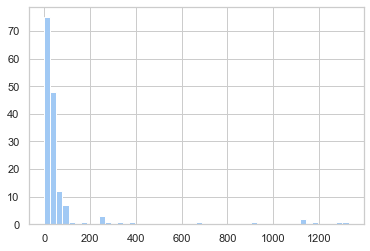

In [38]:
stats_sizing.xs(2, level='a')['btms_size'].xs(1e6,level='d').hist(bins=50)
ax = plt.gca()
#ax.set_xlim(0,)

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

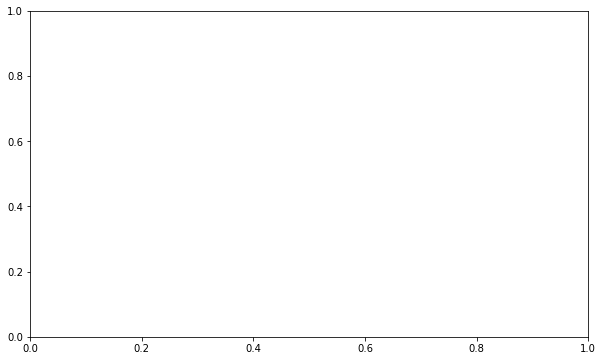

In [7]:
import matplotlib.pyplot as plt

stat_selected = 'grid_peak_to_charge_peak_ratio'

# plot results for all demand charges at every wait time cost

fig, ax = plt.subplots(figsize=(10, 6))
a = stats_sizing.index.get_level_values('a').unique()
for d in stats_sizing.index.get_level_values('d').unique():
    # plot mean for each demand charge
    y = stats_sizing.xs(d, level='d')[stat_selected].groupby('a').mean()
    ax.plot(a, y, label='wait cost ' + str(d), marker='o')
    ax.set_title('mean of ' + stat_selected )
    ax.set_xlabel('demand charge')
    ax.set_ylabel(stat_selected)
fig.legend()

Text(0.5, 1.0, 'box plot')

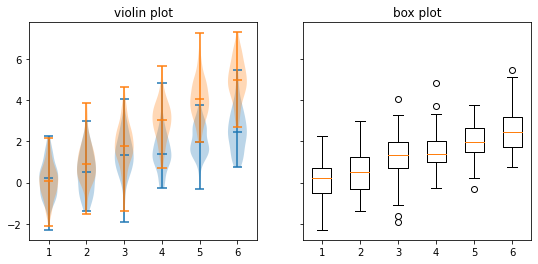

In [8]:
#test violin plot
import numpy as np

data = np.random.normal(size=(100, 6)) + np.arange(6) / 2
data2 = np.random.normal(size=(100, 6)) + np.arange(6) 
labels = list('ABCDEF')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)
axes[0].violinplot(data, showmeans=False, showmedians=True)
axes[0].violinplot(data2, showmeans=False, showmedians=True)
axes[0].set_title('violin plot')
axes[1].boxplot(data)
axes[1].set_title('box plot')


In [9]:
df = stats_sizing.reset_index()
df

,a,d,station_id,btms_size,cost_a,cost_b_sys,cost_b_cap,cost_b_loan,cost_b,cost_c,...,share_cost_b_loan,share_cost_b,share_cost_c,E_Charge,c_rate,cycles_day,btms_ratio,load_factor,btms_peak_to_grid_ratio,grid_peak_to_charge_peak_ratio
0,2.0,1.0,18,4.910068e-05,19.726027,1.123780e-06,7.076471e-07,2.855880e-07,1.831427e-06,5.496676e-07,...,0.0,0.0,0.0,843.541667,0.529309,0.529316,3.081032e-08,0.117978,8.663148e-08,0.500000
1,2.0,1.0,21,4.553457e-07,19.726027,4.720241e-09,5.140708e-09,2.074656e-09,9.860949e-09,3.993047e-09,...,0.0,0.0,0.0,1149.916667,0.239739,0.414637,1.641886e-10,0.160828,3.638804e-10,1.000000
2,2.0,1.0,42,1.520075e-05,10.866618,2.627331e-07,2.218506e-07,8.953315e-08,4.845837e-07,1.722304e-07,...,0.0,0.0,0.0,317.916667,0.399729,0.536072,2.563154e-08,0.080715,3.676669e-08,0.550877
3,2.0,1.0,56,3.187161e-06,14.559713,7.346067e-08,4.999575e-08,2.017699e-08,1.234564e-07,3.882712e-08,...,0.0,0.0,0.0,388.208333,0.533048,0.576142,4.730082e-09,0.073561,7.672488e-09,0.369048
4,2.0,1.0,60,2.179134e-06,7.080235,5.330956e-08,3.618539e-08,1.460348e-08,8.949495e-08,2.808826e-08,...,0.0,0.0,0.0,149.541667,0.565766,0.609940,8.888091e-09,0.058270,1.144963e-08,0.358929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5490,15.0,1000000.0,1424,4.036332e+02,22.670123,1.098422e+01,2.044246e+01,8.250045e+00,3.142668e+01,1.610411e+01,...,0.0,0.0,0.0,961.416667,0.629359,1.855430,7.789683e-01,1.000000,5.525999e+00,0.153233
5491,15.0,1000000.0,1430,2.579485e+02,16.179000,2.452533e+01,1.621011e+01,6.541981e+00,4.073544e+01,1.254921e+01,...,0.0,0.0,0.0,677.333333,2.198860,2.309376,8.794784e-01,1.000000,1.728855e+01,0.054679
5492,15.0,1000000.0,1440,2.946391e+02,4.851192,3.200454e+01,5.286703e+00,2.133576e+00,3.729124e+01,4.094217e+00,...,0.0,0.0,0.0,200.333333,2.512100,0.659339,9.697193e-01,1.000000,7.524168e+01,0.013116
5493,15.0,1000000.0,1442,2.224523e+02,11.404572,1.197200e+01,1.167630e+01,4.712253e+00,2.364830e+01,9.040179e+00,...,0.0,0.0,0.0,475.833333,1.244645,1.928870,9.017474e-01,1.000000,1.197245e+01,0.077086


In [10]:
print(stats_sizing.columns)

Index(['btms_size', 'cost_a', 'cost_b_sys', 'cost_b_cap', 'cost_b_loan',
       'cost_b', 'cost_c', 'cost_total', 'share_cost_a', 'share_cost_b_sys',
       'share_cost_b_cap', 'share_cost_b_loan', 'share_cost_b', 'share_cost_c',
       'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor',
       'btms_peak_to_grid_ratio', 'grid_peak_to_charge_peak_ratio'],
      dtype='object')


(0.0, 300.0)

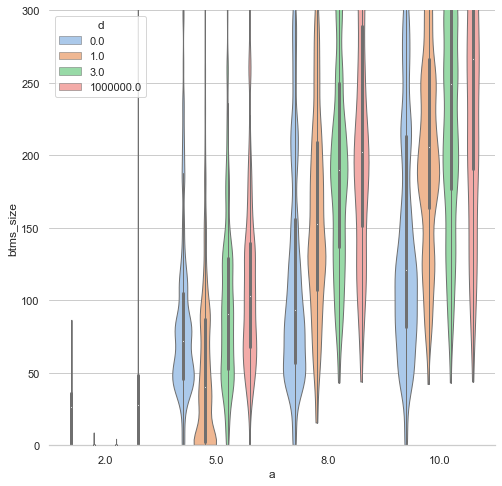

In [19]:
# make violinplots with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# select entries a 1:10, d 1:10


# remove multi index from stats_sizing
df = stats_sizing.reset_index()
# get all a <= 10 and d <= 10 or d > 20
df = df[((df['a'] <= 10) & (df['a'] >1)) & ((df['d'] < 5) | (df['d'] > 20))]

sns.set(style="whitegrid", palette="pastel", color_codes=True)

f, ax = plt.subplots(figsize=(8, 8))

sns.violinplot(x="a", y="btms_size", hue="d", data=df, bw=.15, cut=0, linewidth=1)
sns.despine(left=True)
ax.set_ylim(-0, 300)
#ax.set_ylim(0,7)